<center><h1>Retrieving the COCO Dataset</h1>
<h2>Matthias Bartolo</h2>

</center>

**<h3> Cloning Dataset </h3>**

In [1]:
do_clone = False

In [2]:
if do_clone:
    !pip install pycocotools
    
    from pycocotools.coco import COCO
    import requests
    import os

    # Specify the version of the COCO dataset you want to download
    coco_version = "2017"  # You can choose 2014 or 2017

    # Specify the data type (train or val)
    data_type = "train"

    # Define the paths for saving the dataset and annotations
    save_dir = "./COCODataset"
    annotation_file = f"{save_dir}/annotations/instances_{data_type}{coco_version}.json"
    image_dir = f"{save_dir}/{data_type}{coco_version}"

    # Create directories if they don't exist
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, "annotations"), exist_ok=True)

    # Download the annotations file
    annotations_url = f"http://images.cocodataset.org/annotations/annotations_trainval{coco_version}.zip"
    annotations_zip_file = f"{save_dir}/annotations_trainval{coco_version}.zip"
    if not os.path.exists(annotation_file):
        print(f"Downloading {annotations_url}...")
        r = requests.get(annotations_url)
        with open(annotations_zip_file, 'wb') as f:
            f.write(r.content)

    # Unzip the annotations file
    import zipfile
    with zipfile.ZipFile(annotations_zip_file, 'r') as zip_ref:
        zip_ref.extractall(save_dir)

    # Initialize the COCO API for accessing the dataset
    coco = COCO(annotation_file)

    # Create the image directory if it doesn't exist
    os.makedirs(image_dir, exist_ok=True)

    # Download images and annotations
    cat_ids = coco.getCatIds()
    for cat_id in cat_ids:
        img_ids = coco.getImgIds(catIds=cat_id)
        for img_id in img_ids:
            img = coco.loadImgs(img_id)[0]
            img_file_name = os.path.join(image_dir, img['file_name'])
            img_url = img['coco_url']
            
            if not os.path.exists(img_file_name):
                print(f"Downloading {img_url}...")
                r = requests.get(img_url)
                with open(img_file_name, 'wb') as f:
                    f.write(r.content)

**<h3> Displaying Images </h3>**

loading annotations into memory...
Done (t=9.41s)
creating index...
index created!


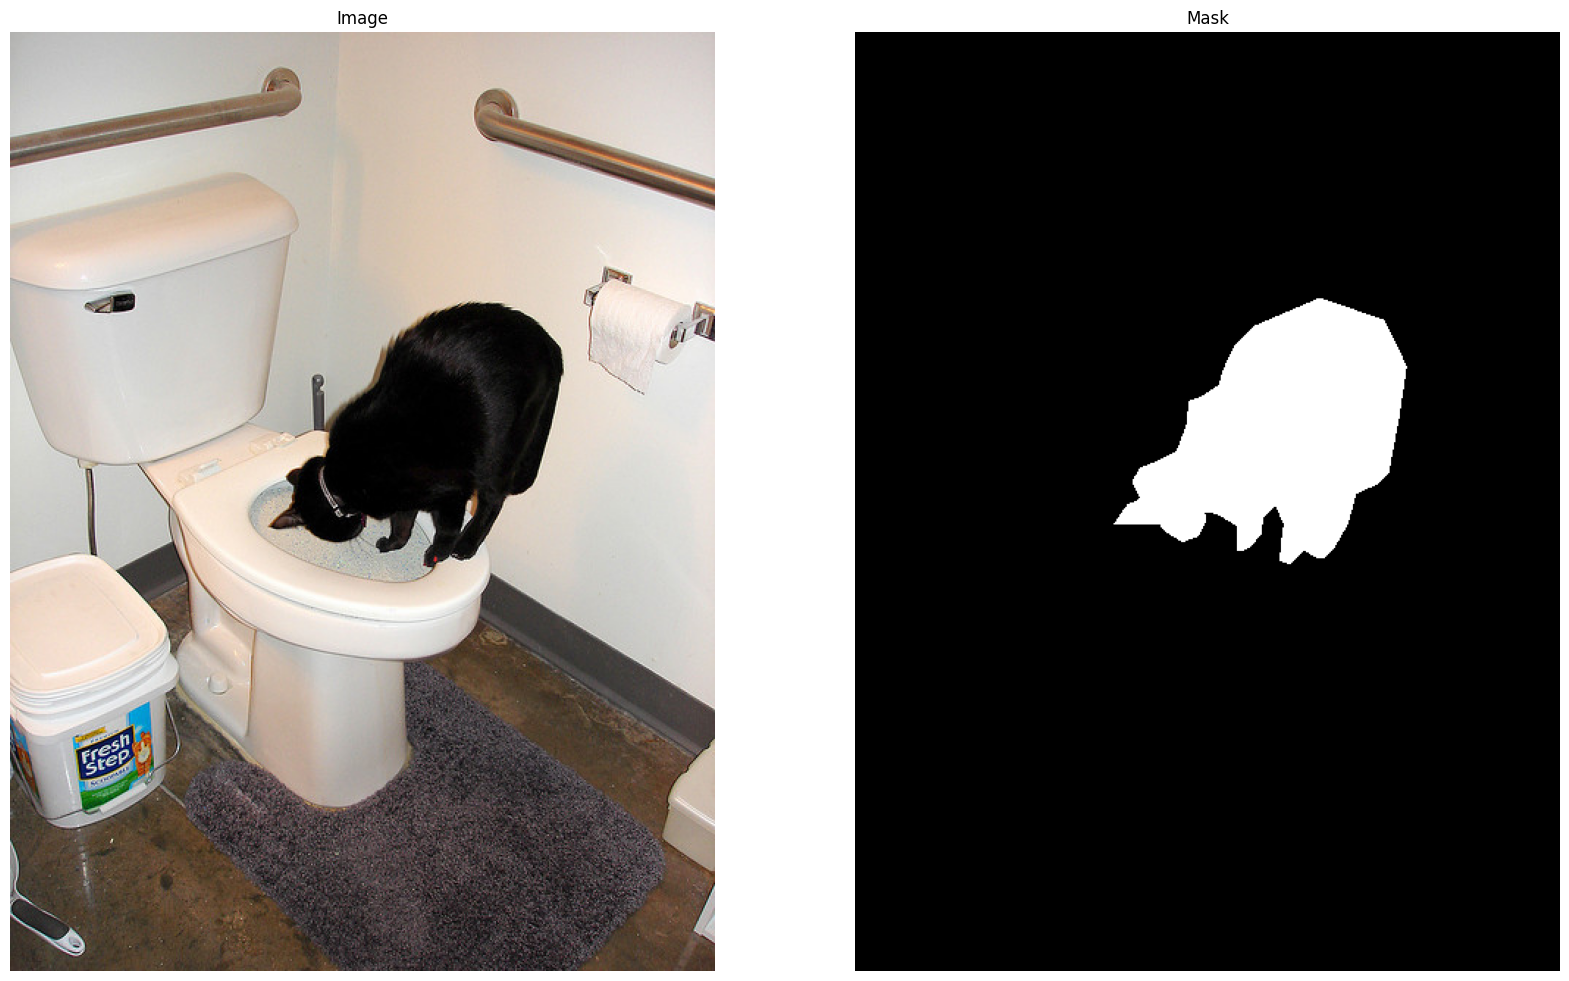

In [3]:
from pycocotools.coco import COCO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Specify the version of the COCO dataset you're working with
coco_version = "2017"  # You can choose 2014 or 2017
data_type = "train"  # You can choose "train" or "val"

# Path to the COCO annotation file
annotation_file = f"./COCODataset/annotations/instances_{data_type}{coco_version}.json"

# Initialize the COCO API
coco = COCO(annotation_file)

# Choose a category (e.g., "car") and get the category ID
category_name = "cat"  # Replace with the category you want
category_id = coco.getCatIds(catNms=[category_name])[0]

# Get all image IDs containing the chosen category
image_ids = coco.getImgIds(catIds=[category_id])

# Select an image ID (e.g., the first image with the chosen category)
image_id = image_ids[0]

# Load the image
image_info = coco.loadImgs(image_id)[0]
path = f"./COCODataset/{data_type}{coco_version}/{image_info['file_name']}"
image = cv2.imread(path)

# Load the corresponding annotation (mask)
ann_ids = coco.getAnnIds(imgIds=image_id, catIds=[category_id], iscrowd=None)
anns = coco.loadAnns(ann_ids)

# Create an empty mask with the same dimensions as the image
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Combine the individual masks into a single mask
for ann in anns:
    mask += coco.annToMask(ann)

# Plot the image and its mask
plt.figure(figsize=(20, 67))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()
